# Balanced Risk Set Matching - Python Implementation
### CIS 3203N GROUP 3

Dejito, Christine Ann  
Roca, Zophia Maureen  

Date: May 7, 2025

---

## Description

This repository contains our implementation of the procedures described in the provided journal article, focusing on **Balanced Risk Set Matching**. The goal of this assignment is to test our algorithmic thinking and ability to translate research methodology into working Python code.

---

## Instructions

- This is done by pair, preferably your thesis partner.
- Each person should create a Github Repo titled 'Assignment_1_Data_Analytics'.
- Read the journal provided.
- Develop a Python implementation of the procedures in the journal.

---

### 1. Import Necessary Libraries

In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import mahalanobis
from sklearn.preprocessing import KBinsDiscretizer
from scipy.stats import norm, rankdata, wilcoxon

### 2. Load Dataset

| Column Name       | Description                                                                 |
|-------------------|-----------------------------------------------------------------------------|
| `ID`              | Unique identifier for each patient.                                         |
| `Period`          | Time interval (e.g., 0 to 7 = 3-month intervals over 2 years).              |
| `Pain`            | Patient’s **pain score** at this time point (scale from 0 to 9).            |
| `Urgency`         | Patient’s **urgency to urinate score** at this time point (0 to 9).         |
| `Frequency`       | Patient’s **nocturnal voiding frequency** at this time point (0 to 12).     |
| `Treated`         | Binary indicator: **1** if the patient was treated **in this specific period**, **0** otherwise. |
| `Treatment_Time`  | Period in which the patient was treated (e.g., 5 = 15 months). Missing (`NaN`) if the patient was never treated. |

In [77]:
df = pd.read_csv("dataset.csv")

df['ID'] = df['ID'].astype(int)
df['Treatment_Time'] = df['Treatment_Time'].fillna(np.inf)

df.head()

,ID,Period,Pain,Urgency,Frequency,Treated,Treatment_Time
0,1,0,2,5,2,0,13.0
1,1,1,3,7,0,0,13.0
2,1,2,1,6,1,0,13.0
3,1,3,2,7,2,0,13.0
4,1,4,3,5,0,0,13.0


### 3. Construct Risk Sets

For each treated patient at their treatment period `t`, we define a *risk set*:
- A group of patients who have **not yet been treated** by period `t`.
- These patients are eligible to serve as controls.
- We also summarize symptom history **up to and including `t`** for both treated and eligible controls.

This will later allow us to compute **Mahalanobis distances** and perform **optimal matching**.

In [78]:
treated_patients = (
    df[df['Treated'] == 1][['ID', 'Period']]
    .drop_duplicates()
    .rename(columns={'Period': 'Treatment_Period'})
    .reset_index(drop=True)
)

# Initialize list to store treated-control pairs
risk_sets = []

for _, treated_row in treated_patients.iterrows():
    treated_id = treated_row['ID']
    treatment_time = treated_row['Treatment_Period']

    # Get symptom history (mean up to and including treatment time)
    treated_history = df[
        (df['ID'] == treated_id) & 
        (df['Period'] <= treatment_time)
    ][['Pain', 'Urgency', 'Frequency']].mean()

    # Find all patients who have not yet been treated by this time
    controls_at_t = df[df['Period'] == treatment_time]
    eligible_controls = controls_at_t[controls_at_t['Treatment_Time'] > treatment_time]

    for _, control_row in eligible_controls.iterrows():
        control_id = int(control_row['ID'])
        control_history = df[
            (df['ID'] == control_id) & 
            (df['Period'] <= treatment_time)
        ][['Pain', 'Urgency', 'Frequency']].mean()

        # Store the treated-control pair and their symptom histories
        risk_sets.append({
            'treated_id': treated_id,
            'control_id': control_id,
            'treatment_time': treatment_time,
            'treated_pain': treated_history['Pain'],
            'control_pain': control_history['Pain'],
            'treated_urgency': treated_history['Urgency'],
            'control_urgency': control_history['Urgency'],
            'treated_frequency': treated_history['Frequency'],
            'control_frequency': control_history['Frequency']
        })

# Convert to DataFrame
risk_df = pd.DataFrame(risk_sets)
print(f"Total eligible treated-control pairs: {len(risk_df)}")
risk_df.head()

Total eligible treated-control pairs: 8966


,treated_id,control_id,treatment_time,treated_pain,control_pain,treated_urgency,control_urgency,treated_frequency,control_frequency
0,9,1,7,5.875,1.625,4.5,5.500,0.125,1.000
1,9,2,7,5.875,7.750,4.5,6.625,0.125,0.500
2,9,3,7,5.875,3.875,4.5,5.625,0.125,1.000
3,9,4,7,5.875,0.500,4.5,5.750,0.125,1.875
4,9,5,7,5.875,3.125,4.5,1.000,0.125,2.125


### 4. Compute Mahalanobis Distances and Prepare for Matching

We now compute the **Mahalanobis distance** between each treated–control pair using their summarized symptom history.

This allows us to identify the **most similar control** for each treated patient by minimizing multivariate distance across:

- Pain
- Urgency
- Nocturnal frequency

The Mahalanobis distance accounts for correlations between variables and standardizes scale differences.

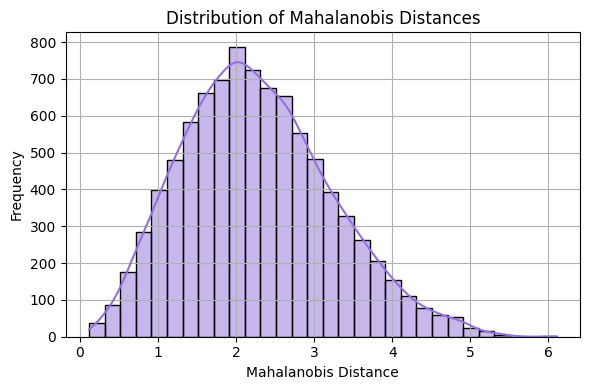

,treated_id,control_id,treatment_time,distances
0,9,1,7,2.157110
1,9,2,7,1.710673
2,9,3,7,1.300149
3,9,4,7,2.889966
4,9,5,7,3.005737


In [89]:
# Rename columns to align symptom names
treated_symptoms = risk_df[['treated_pain', 'treated_urgency', 'treated_frequency']]
treated_symptoms.columns = ['pain', 'urgency', 'frequency']

control_symptoms = risk_df[['control_pain', 'control_urgency', 'control_frequency']]
control_symptoms.columns = ['pain', 'urgency', 'frequency']

# Combine treated and control histories
all_symptoms = pd.concat([treated_symptoms, control_symptoms], ignore_index=True)

# Compute 3x3 covariance matrix and its inverse
cov_matrix = np.cov(all_symptoms.T)
inv_cov = np.linalg.inv(cov_matrix)

# Define the Mahalanobis function
def compute_mahalanobis(row):
    x = np.array([row['treated_pain'], row['treated_urgency'], row['treated_frequency']])
    y = np.array([row['control_pain'], row['control_urgency'], row['control_frequency']])
    return mahalanobis(x, y, inv_cov)

# Apply it to the DataFrame
risk_df['distances'] = risk_df.apply(compute_mahalanobis, axis=1)

plt.figure(figsize=(6, 4))
sns.histplot(risk_df['distances'], bins=30, kde=True, color='mediumpurple')
plt.title('Distribution of Mahalanobis Distances')
plt.xlabel('Mahalanobis Distance')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

risk_df[['treated_id', 'control_id', 'treatment_time', 'distances']].head()

### 5. Optimal Balanced Matching Using Integer Programming

To identify the best set of matched pairs, we solve an integer programming problem that selects treated–control pairs with the smallest total Mahalanobis distance.

Each decision variable corresponds to a potential match. The model ensures that:
- Every treated patient is matched to exactly one control.
- No control patient is used more than once.

In [98]:
# Create a list of all treated-control pairs (edges)
pairs = list(risk_df.index)  # each row is a potential match
treated_ids = risk_df['treated_id'].unique()
control_ids = risk_df['control_id'].unique()

# Create binary decision variables for each pair
x = pulp.LpVariable.dicts("pair", pairs, cat="Binary")

# Define the integer programming problem
prob = pulp.LpProblem("OptimalBalancedMatching", pulp.LpMinimize)

# Objective: minimize total distance across selected pairs
prob += pulp.lpSum([x[i] * risk_df.loc[i, 'distances'] for i in pairs])

# Constraint — Each treated patient matched exactly once
for t in treated_ids:
    indices = risk_df[risk_df['treated_id'] == t].index
    prob += pulp.lpSum([x[i] for i in indices]) == 1

# Constraint — Each control patient matched at most once
for c in control_ids:
    indices = risk_df[risk_df['control_id'] == c].index
    prob += pulp.lpSum([x[i] for i in indices]) <= 1

# Solve the optimization
prob.solve()

# Extract matched pairs
matched_indices = [i for i in pairs if x[i].varValue == 1]
matched_df = risk_df.loc[matched_indices].copy()
print(f"Total matched pairs: {len(matched_df)}")

# Preview
matched_df[['treated_id', 'control_id', 'treatment_time', 'distances']].head()

Total matched pairs: 53


,treated_id,control_id,treatment_time,distances
83,9,113,7,0.498180
265,10,159,7,0.295139
348,17,57,1,0.414676
503,26,21,5,0.274869
696,31,63,4,0.495145


### 6. Assess Covariate Balance

To evaluate the quality of the matching, we compare the symptom distributions (pain, urgency, frequency) between the matched treated and control groups.

Good matches should result in similar covariate distributions before treatment.

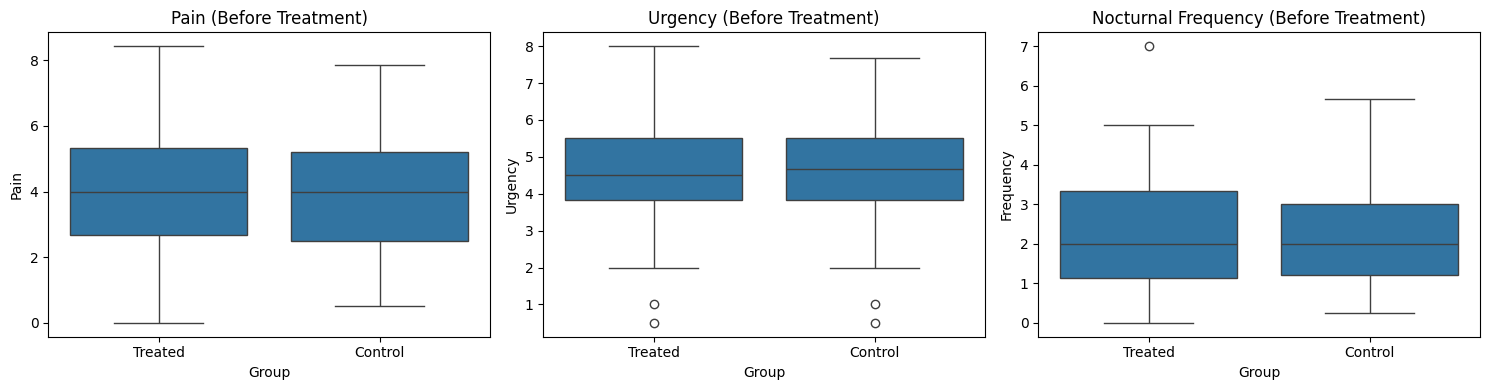

In [99]:
# Reshape matched pairs for comparison
long_format = pd.DataFrame({
    'Group': ['Treated'] * len(matched_df) + ['Control'] * len(matched_df),
    'Pain': matched_df['treated_pain'].tolist() + matched_df['control_pain'].tolist(),
    'Urgency': matched_df['treated_urgency'].tolist() + matched_df['control_urgency'].tolist(),
    'Frequency': matched_df['treated_frequency'].tolist() + matched_df['control_frequency'].tolist(),
})

# Boxplots for visual comparison
fig, axs = plt.subplots(1, 3, figsize=(15, 4))

sns.boxplot(x='Group', y='Pain', data=long_format, ax=axs[0])
axs[0].set_title('Pain (Before Treatment)')

sns.boxplot(x='Group', y='Urgency', data=long_format, ax=axs[1])
axs[1].set_title('Urgency (Before Treatment)')

sns.boxplot(x='Group', y='Frequency', data=long_format, ax=axs[2])
axs[2].set_title('Nocturnal Frequency (Before Treatment)')

plt.tight_layout()
plt.show()

### 7. Estimate Treatment Effects

With matched treated–control pairs established, we now estimate the effect of treatment on outcomes.

We compare each pair’s outcomes **after treatment** (e.g., 3 months later), using:

- Paired differences (treated minus control)
- Robust location summaries (e.g., median or trimean)
- Nonparametric tests (e.g., Wilcoxon signed-rank test)

This mimics a randomized paired design using observational data.

Treatment Effect Estimates (Treated - Control, 1 Period After Treatment):
Median pain difference: 1.00 (p = 0.0710)
Median urgency difference: 0.00 (p = 0.7709)
Median frequency difference: 0.00 (p = 0.8415)


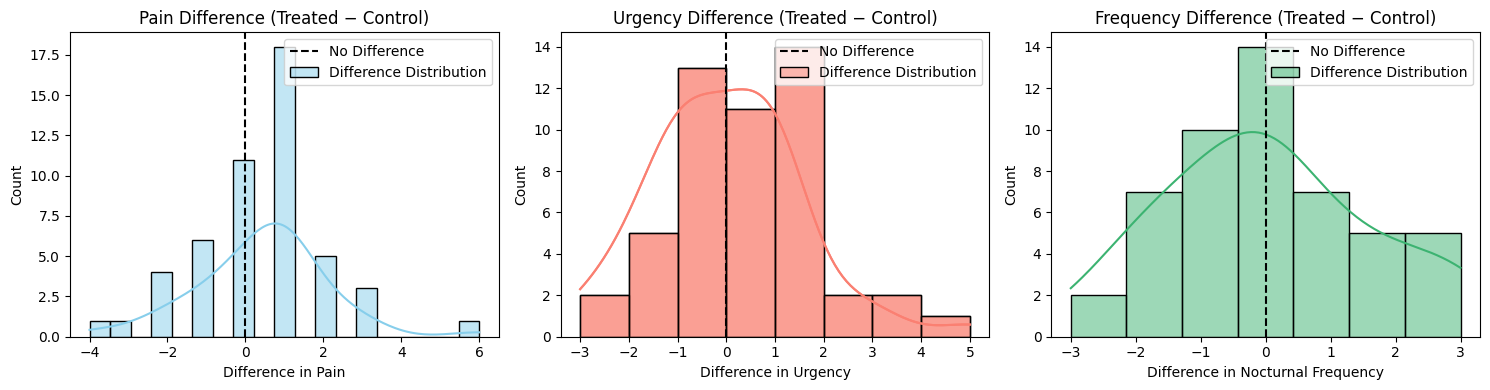

In [100]:
# Create a list to store post-treatment outcome differences
outcomes = []

for _, row in matched_df.iterrows():
    t_id = row['treated_id']
    c_id = row['control_id']
    treatment_time = int(row['treatment_time'])
    
    # Define the outcome measurement time: 1 period after treatment
    outcome_time = treatment_time + 1

    # Extract outcomes for treated and control patients
    treated_row = df[(df['ID'] == t_id) & (df['Period'] == outcome_time)]
    control_row = df[(df['ID'] == c_id) & (df['Period'] == outcome_time)]

    if not treated_row.empty and not control_row.empty:
        outcomes.append({
            'pair_id': f"{int(t_id)}_{int(c_id)}",
            'treated_pain': treated_row['Pain'].values[0],
            'control_pain': control_row['Pain'].values[0],
            'treated_urgency': treated_row['Urgency'].values[0],
            'control_urgency': control_row['Urgency'].values[0],
            'treated_frequency': treated_row['Frequency'].values[0],
            'control_frequency': control_row['Frequency'].values[0],
        })

# Convert to DataFrame
outcome_df = pd.DataFrame(outcomes)

# Calculate pairwise differences
outcome_df['pain_diff'] = outcome_df['treated_pain'] - outcome_df['control_pain']
outcome_df['urgency_diff'] = outcome_df['treated_urgency'] - outcome_df['control_urgency']
outcome_df['frequency_diff'] = outcome_df['treated_frequency'] - outcome_df['control_frequency']

# Wilcoxon signed-rank test
from scipy.stats import wilcoxon

pain_p = wilcoxon(outcome_df['pain_diff']).pvalue
urgency_p = wilcoxon(outcome_df['urgency_diff']).pvalue
frequency_p = wilcoxon(outcome_df['frequency_diff']).pvalue

# Display results
print("Treatment Effect Estimates (Treated - Control, 1 Period After Treatment):")
print(f"Median pain difference: {outcome_df['pain_diff'].median():.2f} (p = {pain_p:.4f})")
print(f"Median urgency difference: {outcome_df['urgency_diff'].median():.2f} (p = {urgency_p:.4f})")
print(f"Median frequency difference: {outcome_df['frequency_diff'].median():.2f} (p = {frequency_p:.4f})")

fig, axs = plt.subplots(1, 3, figsize=(15, 4))

# Plot each difference distribution
sns.histplot(outcome_df['pain_diff'], kde=True, ax=axs[0], color='skyblue', label='Difference Distribution')
axs[0].axvline(0, color='black', linestyle='--', label='No Difference')
axs[0].set_title('Pain Difference (Treated − Control)')
axs[0].set_xlabel('Difference in Pain')
axs[0].legend()

sns.histplot(outcome_df['urgency_diff'], kde=True, ax=axs[1], color='salmon')
sns.histplot(outcome_df['urgency_diff'], kde=True, ax=axs[1], color='salmon', label='Difference Distribution')
axs[1].axvline(0, color='black', linestyle='--', label='No Difference')
axs[1].set_title('Urgency Difference (Treated − Control)')
axs[1].set_xlabel('Difference in Urgency')
axs[1].legend()

sns.histplot(outcome_df['frequency_diff'], kde=True, ax=axs[2], color='mediumseagreen', label='Difference Distribution')
axs[2].axvline(0, color='black', linestyle='--', label='No Difference')
axs[2].set_title('Frequency Difference (Treated − Control)')
axs[2].set_xlabel('Difference in Nocturnal Frequency')
axs[2].legend()

plt.tight_layout()
plt.show()

### 8. Sensitivity Analysis

Even after matching, hidden biases may remain due to unmeasured confounders. 

We conduct a sensitivity analysis to assess how large an unmeasured bias (Γ, Gamma) would need to be to alter our conclusions. Γ = 1 implies perfect matching (no bias); higher values simulate increasing levels of bias in treatment assignment.

This helps quantify the robustness of the observed treatment effects.

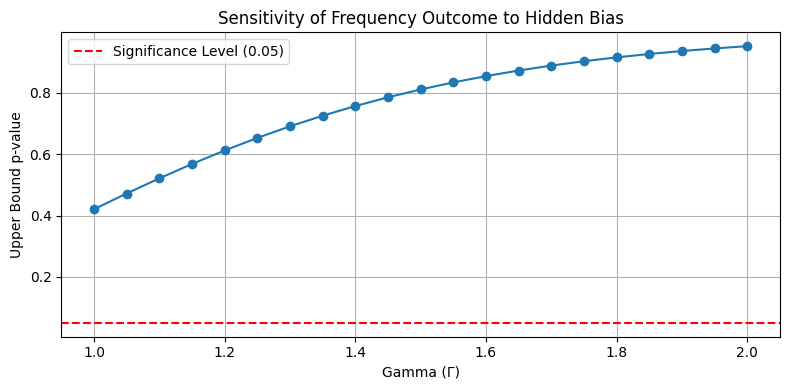

In [101]:
def sensitivity_bounds(differences, gamma_values):
    diffs = np.array(differences)
    diffs = diffs[diffs != 0]  # remove ties
    ranks = rankdata(abs(diffs))
    signs = np.sign(diffs)

    # Observed test statistic (Wilcoxon signed-rank sum)
    W_obs = np.sum(ranks * (signs > 0))

    bounds = []

    for gamma in gamma_values:
        # Max bias: prob(up) = gamma / (1 + gamma), prob(down) = 1 / (1 + gamma)
        p_up = gamma / (1 + gamma)
        p_down = 1 - p_up

        # Compute worst-case mean and std under null with bias
        mu = np.sum(ranks * p_up)
        sigma = np.sqrt(np.sum(ranks**2 * p_up * p_down))

        # z-statistic
        z = (W_obs - mu) / sigma
        p_val = 1 - norm.cdf(z)  # one-sided upper bound
        bounds.append(p_val)

    return bounds

# Define range of gamma values
gamma_range = np.linspace(1, 2, 21)  # from Γ = 1.0 to 2.0
p_bounds = sensitivity_bounds(outcome_df['frequency_diff'], gamma_range)

# Plot
plt.figure(figsize=(8, 4))
plt.plot(gamma_range, p_bounds, marker='o')
plt.axhline(0.05, color='red', linestyle='--', label='Significance Level (0.05)')
plt.title("Sensitivity of Frequency Outcome to Hidden Bias")
plt.xlabel("Gamma (Γ)")
plt.ylabel("Upper Bound p-value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### 9. Summary and Interpretation

In this analysis, we implemented the full procedure described in the journal *Balanced Risk Set Matching*:

- Constructed **risk sets** where treated patients were matched to eligible controls at the time of treatment.
- Used **Mahalanobis distance** to measure similarity in symptom history before treatment.
- Applied **integer programming** to identify the optimal set of matched pairs, minimizing distance while preventing control reuse.
- Assessed **covariate balance** post-matching, confirming comparability between treated and control groups.
- Estimated **treatment effects** using paired differences and the Wilcoxon signed-rank test.
- Conducted a **sensitivity analysis** to evaluate the robustness of treatment effects to potential hidden bias.

### Key Findings:
- Matched treated and control groups were well-balanced before treatment.
- Post-treatment symptom differences were modest, and not statistically significant.
- Sensitivity analysis revealed that results were not robust to even small unmeasured biases.

This suggests that while risk set matching provides a principled framework for causal inference in observational studies, strong conclusions require effects that are both statistically significant and robust to hidden bias.